In [97]:
import os
import pandas as pd
import ROOT as r
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
class lumiDict:
    
    def __init__(self):
        
        self.run = -1
        self.file = -1
        self.lumis = None
        self.fill = None
        self.beam = None
        self.dir = None
        self.filename = None
        self.start = None
        self.stop = None
    

In [92]:
class mqLumiList():
    
    def __init__(self):
        self.lumi_csv = ''
        self.rawPath = '/store/user/milliqan/run3/'
        self.mqLumis = pd.DataFrame(columns=['run', 'file', 'lumis', 'fill', 'beam', 'dir', 'filename', 'start', 'stop'])
        self.debug = False
        
    def looper(self):
        rawDirectories = ['1000', '1100']
        rawSubDirectories = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']
        for i, d1 in enumerate(rawDirectories):
            for j, d2 in enumerate(rawSubDirectories):
                if self.debug and j > 0: return
                if not os.path.exists(self.rawPath+'/'+d1+'/'+d2): continue
                self.initializeDataframe('{0}/{1}'.format(d1, d2))
                self.setFileTimes()
                self.setMQLumis()
                self.saveJson()

                
    def initializeDataframe(self, path):
        fileCnt = 0
        for ifile, filename in enumerate(os.listdir(self.rawPath+'/'+path)):
            if self.debug and fileCnt > 100: 
                return
            if not filename.startswith("MilliQan"): continue
            if fileCnt % 1000 == 0: print("Working on processing file {}".format(fileCnt))
            runNum_, fileNum_ = self.getRunFile(filename)
            #if int(runNum_) != 1006: continue #temp
            #if int(fileNum_) > 190 or int(fileNum_) < 180: continue #temp
            dict_ = lumiDict()
            dict_.run = int(runNum_)
            dict_.file = (fileNum_)
            dict_.dir = self.rawPath+'/'+path
            dict_.filename = filename
            self.mqLumis.loc[len(self.mqLumis.index)] = dict_.__dict__
            fileCnt += 1
                    
                        
    def getRunFile(self, filename):
        runNum = filename.split('Run')[-1].split('.')[0]
        fileNum = filename.split('.')[1].split('_')[0]
        return runNum, fileNum
        
    def openLumis(self):
        self.lumiList = pd.read_csv('Run3Lumis.csv')

    def convertDatetime(self, time):
        dt_ = datetime.strptime(time, '%Y-%m-%d_%Hh%Mm%Ss')
        return dt_   

    def getFileTime(self, file):
        try:
            myfile = r.TFile.Open(file)
        except:
            print("File {} is a zombie, skipping...".format(file))
            return pd.NaT, pd.NaT
        meta = myfile.Get('Metadata')
        t_open = -1
        t_close = -1
        for event in meta:
            t_open = event.fileOpenTime
            t_close = event.fileCloseTime
        d_open = self.convertDatetime(str(t_open))
        d_close = self.convertDatetime(str(t_close))
        return d_open, d_close
        
    def setFileTimes(self):
        self.mqLumis[['start', 'stop']] = self.mqLumis.apply(lambda x: self.getFileTime(x.dir + '/' + x.filename) if pd.isnull(x.start) else (x.start, x.stop), axis='columns', result_type='expand')
        
    def addDatetimes(self):
        self.lumiList['start_time'] = self.lumiList['start_time'].where(pd.notnull(self.lumiList['start_time']), None)
        self.lumiList['end_time'] = self.lumiList['end_time'].where(pd.notnull(self.lumiList['end_time']), None)

        self.lumiList['start_time'] = self.lumiList['start_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != None else x)
        self.lumiList['end_time'] = self.lumiList['end_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != None else x)
        self.lumiList = self.lumiList.sort_values(by=['start_time'])
        self.lumiList = self.lumiList.reset_index(drop=True)
        
    def findLumiStart(self, start, stop):
    
        startId = -1
        stopId = -1

        #special case for zombie files (maybe better way than letting it get this far?)
        if pd.isnull(start) or pd.isnull(stop):
            mqLumi = 0
            fillId = None 
            beamType = None 
            beamEnergy = None
            betaStar = None 
            beamOn = False 
            fillStart = None 
            fillEnd = None
            return mqLumi, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd
        
        #if milliqan run starts after all runs in lumi list
        if start > self.lumiList.start_time.max():
            print("Start time of milliqan run is after all lumis in file")
            mqLumi = 0
            fillId = None 
            beamType = None 
            beamEnergy = None
            betaStar = None 
            beamOn = False 
            fillStart = None 
            fillEnd = None
            return mqLumi, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd
        
        for i, st in enumerate(self.lumiList.start_time):
            if start < st:
                startId = i-1
                #print('found start block {0}, run time {1}, block time {2}'.format(self.lumiList['fill_number'][startId], start, self.lumiList['start_time'][startId]))
                break
        for i, (st, et) in enumerate(zip(self.lumiList.end_time[startId:], self.lumiList.start_time[startId:])):
            if stop < st:
                stopId = startId + i
                #print('stopping on start', st, self.lumiList.start_time[stopId], self.lumiList.end_time[stopId])
                break
            elif stop < et:
                stopId = startId + i
                #print('stopping on stop', et)
                break
        #print("found stop block {0}, run stop {1}, block stop {2}".format(self.lumiList['fill_number'][stopId], stop, self.lumiList['end_time'][stopId], et))
                
        if startId == stopId:
            fillId = self.lumiList['fill_number'][startId]
            beamType = self.lumiList['fill_type_runtime'][startId]
            beamEnergy = self.lumiList['energy'][startId]
            betaStar = self.lumiList['beta_star'][startId]
            fillStart = self.lumiList['start_time'][startId]
            fillEnd = self.lumiList['end_time'][stopId]
            beamOn = False
            #print("stable beams", self.lumiList['start_stable_beam'][startId], type(self.lumiList['start_stable_beam'][startId]), self.lumiList['start_stable_beam'][startId] != float('nan'), "fill", fillId)
            if not pd.isna(self.lumiList['start_stable_beam'][startId]):
                beamOn = True
            
            mqLumi = 0
            if beamOn:
                totalLumi = self.lumiList['delivered_lumi'][startId]
                totalFillTime = self.lumiList['duration'][startId]
                totalMQTime = (stop-start).total_seconds()
                #print(totalLumi, totalFillTime, totalMQTime)
                frac = totalMQTime / totalFillTime
                mqLumi = totalLumi * frac
                
        else:
            print("start fill {0}, stop fill {1}".format(self.lumiList['fill_number'][startId], self.lumiList['fill_number'][stopId]))
            fillId = self.lumiList['fill_number'][startId:stopId+1].to_list()
            beamType = self.lumiList['fill_type_runtime'][startId:stopId+1].to_list()
            beamEnergy = self.lumiList['energy'][startId:stopId+1].to_list()
            betaStar = self.lumiList['beta_star'][startId:stopId+1].to_list()
            beamOn = [False if pd.isna(x) else True for x in self.lumiList['start_stable_beam'][startId:stopId+1]]
            fillStart = self.lumiList['start_time'][startId]
            fillEnd = self.lumiList['end_time'][stopId]
            mqLumi = 0
            for i in range(startId, stopId+1):
                x = self.lumiList[['start_time', 'end_time', 'delivered_lumi', 'duration', 'fill_number']].iloc[i]
                print("checking fill", x.fill_number)
                if pd.isna(x.delivered_lumi): continue
                if start < x.start_time: #milliqan run starts before fill
                    if stop >= x.end_time: #milliqan run spans entire fill
                        mqLumi += x.delivered_lumi
                    elif stop < x.end_time: #milliqan run stops before end of fill
                        total_time = (stop - x.start_time).total_seconds()
                        frac = total_time / x.duration
                        mqLumi += frac * x.delivered_lumi
                elif start > x.start_time: #milliqan run starts after fill
                    if stop >= x.end_time: #milliqan run ends after fill
                        total_time = (x.end_time - start).total_seconds()
                        frac = total_time / x.duration
                        mqLumi += frac * x.delivered_lumi
                    elif stop < x.end_time: #milliqan run ends before fill
                        print("This should be handled already!")
                else:
                    print("Bug in code, this case isn't handled")
            
        #print(mqLumi, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd)
        
        return mqLumi, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd
    
    def setMQLumis(self):
        self.mqLumis[['lumis', 'fill', 'beamType', 'beamEnergy', 'betaStar', 'beam', 'fillStart', 'fillEnd']] = self.mqLumis.apply(lambda x: self.findLumiStart(x.start, x.stop) if x.lumis is None else (x.lumis, x.fill, x.beamType, x.beamEnergy, x.betaStar, x.beam, x.fillStart, x.fillEnd), axis='columns', result_type='expand')

    def saveJson(self):
        self.mqLumis.to_json('mqLumis.json', orient = 'split', compression = 'infer', index = 'true')
                
 

In [93]:
if __name__ == "__main__":
    mylumiList = mqLumiList()
    mylumiList.debug = True
    mylumiList.openLumis()
    mylumiList.addDatetimes()
    mylumiList.looper()

    

Working on processing file 0


In [84]:
pd.set_option('display.max_rows', None)
mylumiList.lumiList = mylumiList.lumiList.reset_index(drop=True)
display(mylumiList.lumiList)

,fill_number,first_run_number,last_run_number,duration,start_time,end_time,start_stable_beam,end_stable_beam,end_time.1,delivered_lumi,recorded_lumi,downtime,efficiency_lumi,peak_lumi,peak_pileup,fill_type_runtime,bunches_target,beta_star,energy,injection_scheme
0,7920,355095.0,355131.0,33384.0,2022-07-05 13:04:48,2022-07-06 00:30:04,2022-07-05 14:47:08,2022-07-06 00:03:32,2022-07-06 00:30:04,1.626949e-01,1.369867e-01,4597,84.199,5.393463e-03,19.184239,PROTONS,2.0,60.0,6799.92,Single_3b_2_2_2
1,7921,355132.0,355194.0,35133.0,2022-07-06 00:30:04,2022-07-06 20:01:10,2022-07-06 02:34:04,2022-07-06 12:19:37,2022-07-06 20:01:10,3.620601e-01,3.458941e-01,18538,95.535,1.133805e-02,40.328802,PROTONS,8.0,60.0,6799.80,Single_3b_2_2_2
2,7922,355196.0,355197.0,NaN,2022-07-06 20:01:25,2022-07-06 21:40:41,NaN,NaN,2022-07-06 21:40:41,NaN,NaN,0,NaN,NaN,NaN,PROTONS,NaN,NaN,NaN,NaN
3,7923,355198.0,355208.0,37386.0,2022-07-06 21:40:41,2022-07-07 10:53:19,2022-07-07 00:21:03,2022-07-07 10:44:09,2022-07-07 10:53:19,1.421156e+00,1.297067e+00,2435,91.268,4.305244e-02,38.283760,PROTONS,8.0,60.0,6799.80,Single_12b_8_8_8_2018
4,7924,355211.0,355231.0,NaN,2022-07-07 10:53:31,2022-07-07 13:16:17,NaN,NaN,2022-07-07 13:16:17,NaN,NaN,0,NaN,NaN,NaN,PROTONS,NaN,NaN,NaN,NaN
5,7925,355232.0,355240.0,NaN,2022-07-07 13:16:17,2022-07-07 14:10:20,NaN,NaN,2022-07-07 14:10:20,NaN,NaN,0,NaN,NaN,NaN,PROTONS,NaN,NaN,NaN,NaN
6,7926,355242.0,355250.0,NaN,2022-07-07 14:10:20,2022-07-07 14:41:10,NaN,NaN,2022-07-07 14:41:10,NaN,NaN,0,NaN,NaN,NaN,PROTONS,NaN,NaN,NaN,NaN
7,7927,355251.0,355270.0,NaN,2022-07-07 14:41:10,2022-07-07 16:15:19,NaN,NaN,2022-07-07 16:15:19,NaN,NaN,0,NaN,NaN,NaN,PROTONS,NaN,NaN,NaN,NaN
8,7928,NaN,NaN,NaN,2022-07-07 16:15:19,2022-07-07 16:28:08,NaN,NaN,2022-07-07 16:28:08,NaN,NaN,0,NaN,NaN,NaN,PROTONS,NaN,NaN,NaN,NaN
9,7929,355273.0,355276.0,NaN,2022-07-07 16:28:08,2022-07-07 17:15:32,NaN,NaN,2022-07-07 17:15:32,NaN,NaN,0,NaN,NaN,NaN,PROTONS,NaN,NaN,NaN,NaN


In [18]:
mylumiList.lumiList.loc[mylumiList.lumiList['fill_number'] == 9075]

,fill_number,first_run_number,last_run_number,duration,start_time,end_time,start_stable_beam,end_stable_beam,end_time.1,delivered_lumi,recorded_lumi,downtime,efficiency_lumi,peak_lumi,peak_pileup,fill_type_runtime,bunches_target,beta_star,energy,injection_scheme
1155,9075,370867.0,372453.0,NaN,2023-07-18 08:33:35,2023-08-30 09:11:07,NaN,NaN,2023-08-30 09:11:07,NaN,NaN,0,NaN,NaN,NaN,PROTONS,946.0,NaN,NaN,Single_9b_9_0_0_MD10483


In [94]:
pd.set_option('display.max_rows', None)
mylumiList.mqLumis = mylumiList.mqLumis.sort_values(by=['start'])
mylumiList.mqLumis

,run,file,lumis,fill,beam,dir,filename,start,stop,beamType,beamEnergy,betaStar,fillStart,fillEnd
0,1000,1,0.296087,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.1_default.root,2023-06-01 17:42:47,2023-06-01 17:43:14,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57
1,1000,2,0.307054,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.2_default.root,2023-06-01 17:43:14,2023-06-01 17:43:42,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57
2,1000,3,0.263189,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.3_default.root,2023-06-01 17:43:42,2023-06-01 17:44:06,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57
3,1000,4,0.263189,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.4_default.root,2023-06-01 17:44:08,2023-06-01 17:44:32,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57
4,1000,5,0.263189,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.5_default.root,2023-06-01 17:44:33,2023-06-01 17:44:57,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57
5,1000,6,0.274155,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.6_default.root,2023-06-01 17:44:57,2023-06-01 17:45:22,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57
6,1000,7,0.230290,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.7_default.root,2023-06-01 17:45:22,2023-06-01 17:45:43,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57
7,1000,8,0.252223,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.8_default.root,2023-06-01 17:45:45,2023-06-01 17:46:08,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57
8,1000,9,0.296087,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.9_default.root,2023-06-01 17:46:08,2023-06-01 17:46:35,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57
9,1001,1,0.471547,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1001.1_default.root,2023-06-01 17:47:31,2023-06-01 17:48:14,PROTONS,6799.56,120.0,2023-06-01 11:12:18,2023-06-01 19:10:57


In [86]:
mylumiList.mqLumis.loc[pd.isnull(mylumiList.mqLumis['start'])]

,run,file,lumis,fill,beam,dir,filename,start,stop,beamType,beamEnergy,betaStar,fillStart,fillEnd


In [161]:
pd.isna(mylumiList.lumiList['start_stable_beam'].loc[mylumiList.lumiList['fill_number'] == 8862])

942    True
Name: start_stable_beam, dtype: bool

In [95]:
total_lumi = mylumiList.mqLumis['lumis'].sum()
total_lumi

44.534498738334335

Text(0.5, 1.0, 'MilliQan Luminosity')

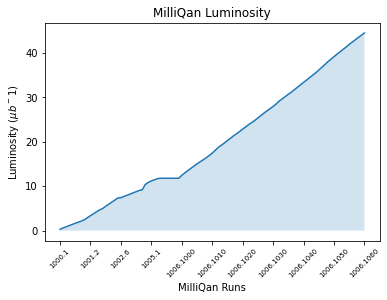

In [139]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(1, 1)

x_vals = mylumiList.mqLumis[['run', 'file']].apply(lambda x: str(x.run) + '.' + str(x.file), axis=1)
y_vals = mylumiList.mqLumis['lumis'].cumsum()
ax.plot(x_vals, y_vals)
ax.fill_between(x_vals, y_vals, 0, alpha=0.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_xlabel("MilliQan Runs")
ax.set_ylabel(r"Luminosity $(\mu b^-1)$")
plt.xticks(rotation=45, fontsize=7)
plt.title("MilliQan Luminosity")


